#### Copyright 2017 Google LLC. - Modificaciones y explicación extendida Harold Molina-Bulla

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introducción a las Redes Neuronales  - Regresión

**Objectivos:**
  * Definir una red neuronal (NN) usando la clase de TensorFlow `DNNRegressor`
  * Entrenar esta red neuronal para predecir el valor de una casa.

## Configuración

Primero: Configurar las librerias que vamos a utilizar:
Las funciones display de IPython y la librería matplotlib son utilizadas para la visualización de datos y gráficas.

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt


Las librerias numpy, pandas y las funciones del módulo metrics de sklearn sirven para la manipulación de estructuras de datos como matrices y "DataFrames".
Los DataFrames sirven para manejar datos estructurados, como si fueran bases de datos. (https://www.geeksforgeeks.org/python-pandas-dataframe/)

In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics


TensorFlow es uno de los Frameworks de trabajo para redes profundas. Provee un conjunto avanzado para la definición de redes neuronales, algoritmos de entrenamiento, validación, evaluación y visualización.
https://www.tensorflow.org/

In [4]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

TensorFlow 1.x selected.


En este bloque se configura el nivel de mensajes de error en TensorFlow y los formatos de presentación numérica en la librería Pandas

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

## **Definición del Problema**:

Se va a entrenar una red neuronal para realizar una regresión no lineal (predicción) del precio de una casa a partir de una serie de características recopiladas, como son:


*   "latitude", "longitude": Ubicación geográfica (latitud y longitud)
*   "housing_median_age": Antigüedad de la casa
*   "total_rooms": Número de estancias
*   "total_bedrooms": Número de habitaciones 
*   "population": Capacidad de la casa (personas)
*   "households": Dueños anteriores
*   "median_income": Media de ingresos

Se van a generar nuevos datos (rooms_per_person), correspondientes al número medio de personas por habitacion.

Existen 2 datasets con formato CSV:

Train:
https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv

Test:
https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv


Con la función read_csv de Pandas, se carga desde el repositorio de GOOGLE el conjunto de datos que nos interesa. En primera instancia, los datos de entrenamiento.

Una vez cargados los datos, se reorganizan de manera aleatoria, para asegurar un mejor entrenamiento.

Tenga en cuenta que esto causa que los resultados varien ligeramente entre ejecución y ejecución.

In [6]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

Para visualizar la estructura de datos cargados, podemos seleccionar los primeros 10 datos con la método DataFrame.head(NNN), y visualizarlos con la función display.display(datos). Observe que si se ejecuta una segunda vez el bloque anterior, los resultados varían.

In [8]:
#Usando las función DataFrame.head(NNN) y display.display, visualice la estructura de los datos cargados.
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3490,-117.9,34.0,15.0,14058.0,2486.0,8997.0,2497.0,5.1,226200.0
805,-117.1,33.1,21.0,4578.0,927.0,2818.0,900.0,3.1,187700.0
15884,-122.4,37.7,52.0,3230.0,654.0,1765.0,611.0,3.3,292300.0
9473,-119.3,34.4,22.0,3527.0,711.0,1483.0,640.0,2.7,234700.0
14082,-122.1,38.0,37.0,1784.0,313.0,788.0,304.0,4.3,189600.0


In [9]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


Es necesario definir dos funciones para preprocesar los datos (sean de train o test):

**preprocess_features**: Como parámetro de entrada se suministra el DataFrame puro y extrae los datos correspondientes a las columnas que nos interesan, regresando el nuevo DataFrame de datos con la columna adicional de **rooms_per_person**.

**preprocess_targets**: Como parámetro de entrada se suministra el DataFrame de entrada y regresa el dato a predecir, correspondiente a **median_house_value**


In [10]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

In [11]:
def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

#SELECCION DE DATOS DE ENTRENAMIENTO Y VALIDACION SOBRE EL CONJUNTO GLOBAL DE ENTRENAMIENTO
El dataset de entrenamiento contiene 17000 datos.

Con los métodos head y tail, seleccione 2 conjuntos de datasets:

training_examples y training_targets con los 12000 primeros datos del Dataset de entrenamiento (california_housing_dataframe)  

In [12]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000)) #INVOCAR_PREPROCESS_FEATURES SOBRE LOS 12000 primeros datos
training_targets = preprocess_targets(california_housing_dataframe.head(12000)) #INVOCAR_PREPROCESS_TARGETS SOBRE LOS 12000 primeros datos

# Double-check that we've done the right thing.
print("Resumen de los ejemplos de entrenamiento:")
display.display(training_examples.describe())


print("Resumen de los datos objetivo de entrenamiento:")
display.display(training_targets.describe())

Resumen de los ejemplos de entrenamiento:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2627.8,535.9,1420.8,498.4,3.9,2.0
std,2.1,2.0,12.6,2185.4,421.8,1161.2,384.7,1.9,1.0
min,32.5,-124.3,2.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1445.0,293.0,779.0,278.0,2.6,1.5
50%,34.2,-118.5,29.0,2116.0,430.0,1156.0,406.0,3.6,1.9
75%,37.7,-118.0,37.0,3136.0,645.0,1704.0,602.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,41.3


Resumen de los datos objetivo de entrenamiento:


,median_house_value
count,12000.0
mean,207.1
std,116.1
min,15.0
25%,118.8
50%,180.2
75%,265.0
max,500.0


Ahora, seleccione y preprocese los últimos 5000 datos, para generar los DataSets de validación.

In [13]:
# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000)) #INVOCAR_PREPROCESS_FEATURES SOBRE LOS 5000 últimos datos
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))#INVOCAR_PREPROCESS_TARGETS SOBRE LOS 5000 últimos datos

print("Resumen de los datos de validación:")
display.display(validation_examples.describe())

print("Resumen de los datos objetivo de validación:")
display.display(validation_targets.describe())

Resumen de los datos de validación:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.3,2681.7,547.7,1450.7,507.9,3.9,2.0
std,2.1,2.0,12.6,2166.5,420.7,1114.9,384.1,1.9,1.5
min,32.6,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1491.8,306.0,815.0,290.0,2.6,1.5
50%,34.2,-118.5,28.0,2160.5,443.0,1193.0,416.0,3.5,1.9
75%,37.7,-118.0,37.0,3186.8,658.0,1764.0,612.2,4.7,2.3
max,41.9,-114.3,52.0,32054.0,5290.0,15507.0,5050.0,15.0,55.2


Resumen de los datos objetivo de validación:


,median_house_value
count,5000.0
mean,207.7
std,115.6
min,15.0
25%,121.5
50%,180.4
75%,265.0
max,500.0


## Construcción una Red Neuronal (Neural Network)

Para implementar una Red Neuronal (NN) como regresor, podemos utilizar el objeto de TensorFlow [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor).

Utilice la variable **`hidden_units`** para definir la estructura de la NN.  El argumento `hidden_units` provee una lista de números enteros, que indican el número de neuronas correspondientes en cada capa. Por ejemplo, si asignamos:

`hidden_units=[3,10]`

Estamos especificando una red neuronal con dos capas ocultas:

* La primera capa oculta contiene 3 nodos o neuronas.
* La segunda capa oculta contiene 10 neuronas.

Si se desea agregar más capas, se agregan más números enteros a esta lista. Por ejemplo, `hidden_units=[10,20,30,40]` creará cuatro capas con 10, 20, 30 y 40 neuronas respectivamente.

Por omisión, todas las capas usan una función de activacióón [ReLu](https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)) plenamente interconectada.

In [14]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

La función **my_input_fn** se utiliza para seleccionar un subconjunto de datos del conjunto que se esté procesando, dependiendo del tamaño de batch que se le indique, y regresa ese subconjunto de datos y sus valores objetivo. Es útil en entrenamiento, validación y posteriormente se debe usar en la fase de Test.

In [15]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

La función **train_nn_regression_model** se encarga de, dados unos hiperparáámetros de entrenamiento: learning_rate,steps,batch_size y topología de la red; unos datos de entrenamiento:  training_examples y training_targets y unos datos de validación: validation_examples y validation_targets, regresar un modelo de NN entrenado. 

La parada de entrenamiento se define por número de iteraciones.

Dentro de esta función existen las siguientes lineas:



```
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
```

Estas lineas definen unas funciones [lambda](https://towardsdatascience.com/python-lambda-function-b6e1fa3420c1) que invocan la función de adaptación de los datasets **my_input_fn** a diversas necesidades:

**training_input_fn** invoca **my_input_fn** y esta devuelve subconjuntos de datos de tamaño batch_size para ir entrenando la NN, de manera iterativa, e incremental, al no definir el parámetro num_epocs. Adicionalmente, baraja los datos de entrenamiento para presentárselos en orden aleatorio al proceso de entrenamiento.

Otro comportamiento, que es el que utilizan las funciones **predict_trainin_input_fn** y **predict_validation_input_fn**, es el de presentar los datos de entrenamiento y validación, solo una vez y sin reordenar, para evaluar la calidad del modelo.

La predicción realizada por el modelo se calcula en las líneas:

```
training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
training_predictions = np.array([item['predictions'][0] for item in training_predictions])

validation_predictions = dnn_regressor.predic(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
```


In [16]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Entrenando modelo...")
  print("RMSE (sobre los datos de entrenamiento):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  periodo %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Entrenamiento del modelo finalizado.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periodos")
  plt.title("Error Root Mean Squared vs. Periodos")
  plt.tight_layout()
  plt.plot(training_rmse, label="entrenamiento")
  plt.plot(validation_rmse, label="validacion")
  plt.legend()

  print("RMSE Final (sobre datos de entrenamiento):   %0.2f" % training_root_mean_squared_error)
  print("RMSE Final (sobre datos de validación): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

## Tarea 1: Entrenar un Modelo de NN

**Ajustar los hiperparámetros para que el RMSE baje de 110.**

Ejecute el siguiente código de entrenamiento.  

El objetivo a vencer es un RMSE inferior a 110, que es el resultado de un regresor lineal básico sobre este conjunto de entrenamiento (Ground truth).

La tarea consiste en cambiar los hiperparámetros para mejorar ese resultado.

El sobre ajuste es un riesgo potencial en las NNs. Se puede observar el sobreajuste si durante el proceso de entrenamiento, el error de validación empieza a crecer y alejarse del error en entrenamiento.

Es recomendable tomar notas de las distintas combinaciones y resultados obtenidos, para quedarse con el mejor.

Una buena prááctica es ejecutar el mismo código, para verificar que los resultados son replicables.


Entrenando modelo...
RMSE (sobre los datos de entrenamiento):
  periodo 00 : 165.44
  periodo 01 : 163.39
  periodo 02 : 168.00
  periodo 03 : 159.57
  periodo 04 : 156.58
  periodo 05 : 144.46
  periodo 06 : 124.69
  periodo 07 : 114.24
  periodo 08 : 106.57
  periodo 09 : 103.30
Entrenamiento del modelo finalizado.
RMSE Final (sobre datos de entrenamiento):   103.30
RMSE Final (sobre datos de validación): 101.62


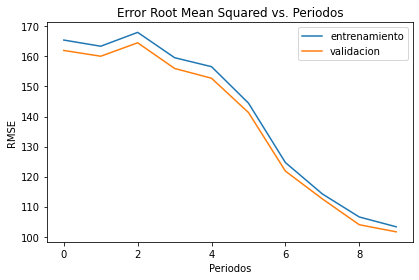

In [27]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=5000,
    batch_size=30, #[0.001, 5000,30,[8,8,8]]=105 y 104. Con mas nodos (15), RMSE similares
    hidden_units=[8,8,8], #[0.001, 5000,30,[8,8,5]]=109 y 107
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 2: Evaluar sobre los datos de Test

**Evaluar la calidad de su regresor sobre el conjunto de Test.**

Una vez se tiene el Modelo debidamente entrenado y con unas prestaciones aceptables, al menos con respecto a los datos de validacióón, se presenta un conjunto de datos completamente nuevo y desconocido, para ver si en producción realmente obtiene buenos resultados.

EL algoritmo es:


*   Descargar los datos de entrenamiento
*   Transformar los datos de entrenamiento en dos datasets: muestras y valores obejetivo (targets), con las funciones **preprocess_features** y **preprocess_targets** 
*   Crear la funcióón lambda similar a las definidas para el proceso de entrenamiento, que presente los datos al Modelo de la NN.
*   Con el modelo entrenado en la fase anterior, realizar la predicción.
*   Calcular el RMSE entre el resultado de la predicción y el valor real

Para calcular el RMSE en validación, usábamos el siguiente código:

```
validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
```

Puede adaptarlo para el caso de TEST

Los datos de entrenamiento están [aquí](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

In [28]:
# Descargamos test dataset 
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# Transformamos los datos de entrenamiento en dos datasets: features y targets
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data) 
# Para comprobar los datos
print("Resumen de los ejemplos de test dataset:")
display.display(test_examples.describe())
print("Resumen de los datos objetivo de test dataset:")
display.display(test_targets.describe())

Resumen de los ejemplos de test dataset:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,35.6,-119.6,28.8,2599.6,530.0,1402.8,489.9,3.8,2.0
std,2.1,2.0,12.6,2155.6,415.7,1030.5,365.4,1.9,1.1
min,32.6,-124.2,1.0,6.0,2.0,5.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1401.0,291.0,780.0,273.0,2.5,1.5
50%,34.3,-118.5,29.0,2106.0,437.0,1155.0,409.5,3.5,1.9
75%,37.7,-118.0,37.0,3129.0,636.0,1742.8,597.2,4.7,2.3
max,41.9,-114.5,52.0,30450.0,5419.0,11935.0,4930.0,15.0,33.8


Resumen de los datos objetivo de test dataset:


,median_house_value
count,3000.0
mean,205.8
std,113.1
min,22.5
25%,121.2
50%,177.6
75%,264.0
max,500.0


In [29]:
# Creamos la funcion lambda que presente los datos de test al modelo de la NN
predict_test_input_fn = lambda: my_input_fn(test_examples, 
                                                  test_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)


#Con el modelo entrenado en la fase anterior, realizamos la predicción
test_predictions = dnn_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
    
# Calculamos el RMSE entre el resultado de la predicción y el valor real 
test_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))     
    
print("Testeo del modelo finalizado.")
print("RMSE Final (sobre datos de test):   %0.2f" % test_root_mean_squared_error)

Testeo del modelo finalizado.
RMSE Final (sobre datos de test):   99.55


# CONCLUSIONES DE LA PRÁCTICA 
## (Roberto Hernández Ruiz)

#**TAREA 1:**

El objetivo es vencer un RMSE menor de 110. Al modificar los distintos hiperparámetros de la función, el error cambia porque el modelo se comporta de manera diferente. Debemos encontrar los parámetros idóneos para reducir en la medida de lo posible el error. Para reducir el error normalmente tendemos a establecer un learning rate bajo, aumentar los pasos (steps), e ir cambiando las hidden units de la NN para ir probando y evaluando el modelo.


1.   Learning rate (LR): hace referencia al tamaño de paso con el que vamos avanzando en el modelo. Si aumentamos este valor, el entrenamiento es más rápido por ser un paso mayor, pero hay más posibilidades de oscilaciones y un comportamiento más "caótico". Por eso si hay oscilaciones debemos probar a disminuir el LR. Con un LR más pequeño, el entrenamiento es más lento porque realiza pequeños ajustes en los pesos de la red, pero aprende mejor con esos pequeños pasos. Fijaremos un LR=0.001.

2.   Steps: el número de pasos tiende a graduarse también teniendo en cuenta el valor del LR.

3. Batch size: se refiere al tamaño de muestras de entrenamiento que entrenará a la vez en un mismo bloque el modelo. Esto define el número de iteraciones al entrenar la red. Al disminuir este parámetro se va ajustando los pesos después de entrenar cada batch y antes de entrenar el siguiente batch, hasta acabar con todas las muestras de entrenamiento; pero también fluctúa más.

4. Hidden units: capas de la red neuronal, definiremos tres capas porque se comporta mejor el modelo obteniendo un error menor. Con hidden units con menos nodos (4,4,4 por ejemplo) tendía a un error muy superior en torno a 200-230, así que probando con más nodos (15,15,15 por ejemplo) obtuvimos un error inferior pero con fluctuaciones, por eso he decidido disminuir un poco el número de nodos en las mismas capas para tener un error menor a 110 pero con un comportamiento menos caótico para cada iteración. Finalmente en (8,8,8) en las capas de la NN se obtiene un RMSE cercano a 100 e incluso inferior a él en algunas ocasiones evaluando el modelo con el test dataset.




#**TAREA 2:**

En la segunda tarea tratamos ahora con el conjunto de datos de test, para los cuales evaluamos el modelo diseñado y entrenado anteriormente. 

En primer lugar, es preciso realizar un ligero "preprocesamiento" de los datos de test descargados. Obtenemos del dataset las características que emplearemos para testear (features) y separadamente los valores objetivo (targets) con los que compararemos las predicciones para conocer el RMSE, de manera análoga a como se lleva a cabo en la Tarea 1 para el conjunto de datos de entrenamiento.

En segundo lugar, creando la función predict_test_input_fcn presentamos los datos al modelo de la NN ya entrenada (no es preciso que volvamos a entrenar otra vez la máquina), y realizamos las predicciones con el modelo entrenado anteriormente. Finalmente obtenemos el RMSE entre los valores que se predicen y los valores objetivo. 

He obtenido resultados aceptables aunque probablemente mejorables, con un RMSE menor a 110, que era el objetivo, porque previamente la máquina entrenada con los datos de entrenamiento ya obtenía resultados relativamente esperados. Es decir, el modelo funciona relativamente bien o de manera similar con los datos desconocidos de test que con los datos de train o de validación.